In [187]:
import os, sys
sys.path.insert(0, 'webapi')
import random
from abc import abstractclassmethod

from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from bson import ObjectId
import tensorflow as tf

import database
from api_enums import (DBCOLLECTIONS, VARTYPE, MLROLE, PROCSTATUS)
from utils import load_bin
from augment import tf_padcrop

In [38]:
# CONNECT TO DATABASE
database.dbclient = None # force re-init of mongo client
client, db = database.init_dbclient(host='127.0.0.1', port=27099, dbname='data', auth=['root', 'rootpass'])
_ = database.InitDataStorage('/media/hdd2/g4sim/data')

In [122]:
# RANDOMLY SAMPLE A SUBSET OF SIMULATIONS
filter = {
    "magnetic_field.2": 1.5,
    "num_particles": 2000,
}
ndocs = db[DBCOLLECTIONS.SIMULATION].aggregate([
    {"$match": filter},
    {"$count": 'num'},
]).next()['num']
print('{} matching documents'.format(ndocs))

# get uniform random sample of docs
sample_size = 100
r = float(sample_size) / ndocs
samples = []
for simdoc in db[DBCOLLECTIONS.SIMULATION].find(filter):
    if random.random() < r:
        samples.append(simdoc)
    if len(samples) >= sample_size:
        break
print('matched {} randomly sampled documents'.format(len(samples)))

17983 matching documents
matched 100 randomly sampled documents


In [192]:
class Cache():
    def __init__(self):
        self.cache = {}
    
    def __getitem__(self, key):
        if key in self.cache:
            return self.cache[key]
        else:
            val = self.lookup(key)
            self.cache[key] = val
            return val
    
    @abstractclassmethod
    def lookup(self, key):
        pass
    
class GeomCache(Cache):
    def lookup(self, key):
        return db[DBCOLLECTIONS.MCGEOM].find_one({'_id': key})
    
class BeamCache(Cache):
    def lookup(self, key):
        return db[DBCOLLECTIONS.BEAMPHOTON].find_one({'_id': key})
    

In [193]:
# COMBINE SAMPLES INTO ARRAYS
zcontext = 10
slice_size = (100,100)
inputs = np.zeros((sample_size, 2*zcontext+1, *slice_size[::-1], 1), np.float64)
geoms  = np.zeros((sample_size, 2*zcontext+1, *slice_size[::-1], 1), np.float64)
labels = np.zeros((sample_size, 2*zcontext+1, *slice_size[::-1], 1), np.float64)

cache_geomdoc = GeomCache()
cache_beamdoc = BeamCache()
for ii, simdoc in enumerate(tqdm(samples)):
    geomdoc = cache_geomdoc[ObjectId(simdoc['geom_id'])]
    beamdoc = cache_beamdoc[ObjectId(simdoc['beam_id'])]
    for beamletdoc in beamdoc['beamlets']:
        if beamletdoc['_id'] == ObjectId(simdoc['subbeam_id']):
            break
        beamletdoc = None
    assert beamletdoc is not None
    
    size = geomdoc['coordsys']['size']
    # remember, beamlet['position'] is stored as (pos_z-axis, pos_x-axis)
    beamlet_iso = beamdoc['isocenter'][2] + (beamletdoc['position'][0] - beamdoc['fmapdims'][1]/2 + 0.5)*beamdoc['beamletsize'][1]
    beamlet_center_idx = int((beamlet_iso - geomdoc['coordsys']['start'][2]) // geomdoc['coordsys']['spacing'][2])
    bbox = slice(max(0, beamlet_center_idx-zcontext), min(size[2], beamlet_center_idx+zcontext+1))

    # load arrays, pad bbox subregion with zeros to match shape: [zcontext*2+1, size[1], size[0]], and embed in batch array
    input_arr = load_bin(database.dbabspath(simdoc['samples'][0]['dosefile']), size)
    label_doc = db[DBCOLLECTIONS.SIMULATION].find_one({'subbeam_id': ObjectId(simdoc['subbeam_id']), 'num_particles': {'$gte': 1e5}})
    label_arr = load_bin(database.dbabspath(
        label_doc['samples'][0]['dosefile']),
        size
    )
    geom_arr  = load_bin(database.dbabspath(
        label_doc['samples'][0]['densfile']),
        size
    )
    input_arr = tf_padcrop(input_arr[..., None], *slice_size)
    label_arr = tf_padcrop(label_arr[..., None], *slice_size)
    geom_arr  = tf_padcrop(geom_arr [..., None], *slice_size)
    if bbox.stop-bbox.start < 2*zcontext+1:
        continue
        # z-axis padding is necessary
        temp = np.zeros((2*zcontext+1, *slice_size))
        temp[bbox.start]
        input_arr = j
        
    inputs[ii] = input_arr.astype(np.float64)[bbox]
    labels[ii] = label_arr.astype(np.float64)[bbox]
    geoms [ii] = geom_arr.astype( np.float64)[bbox]





  0%|          | 0/100 [00:00<?, ?it/s]



  1%|          | 1/100 [00:00<00:16,  6.05it/s]



  2%|▏         | 2/100 [00:00<00:15,  6.36it/s]



  3%|▎         | 3/100 [00:00<00:14,  6.52it/s]



  4%|▍         | 4/100 [00:00<00:14,  6.67it/s]



  5%|▌         | 5/100 [00:00<00:14,  6.70it/s]



  6%|▌         | 6/100 [00:00<00:13,  6.74it/s]



  7%|▋         | 7/100 [00:01<00:13,  6.75it/s]



  8%|▊         | 8/100 [00:01<00:13,  6.86it/s]



  9%|▉         | 9/100 [00:01<00:13,  6.91it/s]



 10%|█         | 10/100 [00:01<00:12,  6.98it/s]



 11%|█         | 11/100 [00:01<00:12,  6.87it/s]



 12%|█▏        | 12/100 [00:01<00:12,  6.80it/s]



 13%|█▎        | 13/100 [00:01<00:13,  6.68it/s]



 14%|█▍        | 14/100 [00:02<00:12,  7.06it/s]



 15%|█▌        | 15/100 [00:02<00:11,  7.43it/s]



 16%|█▌        | 16/100 [00:02<00:10,  7.68it/s]



 17%|█▋        | 17/100 [00:02<00:10,  7.77it/s]



 18%|█▊        | 18/100 [00:02<00:10,  7.96it/s]



 19%|█▉        | 19/100 [0

INPUTS: shape=(100, 21, 100, 100, 1), size=160MB
LABELS: shape=(100, 21, 100, 100, 1), size=160MB


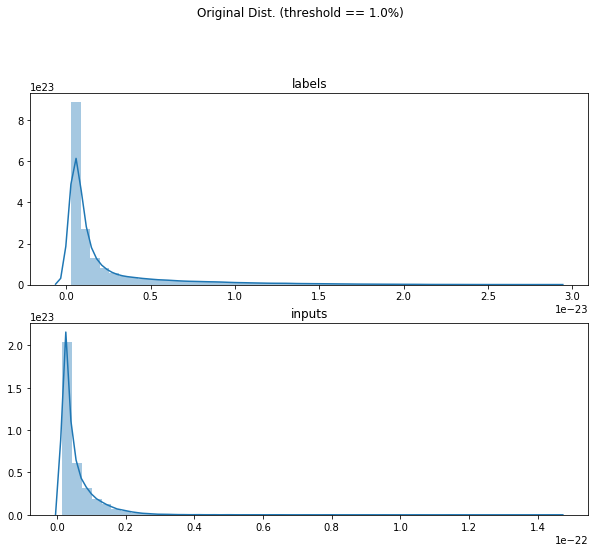

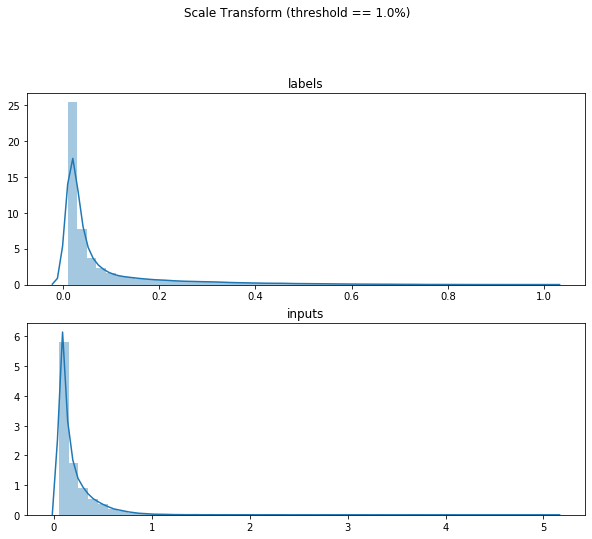

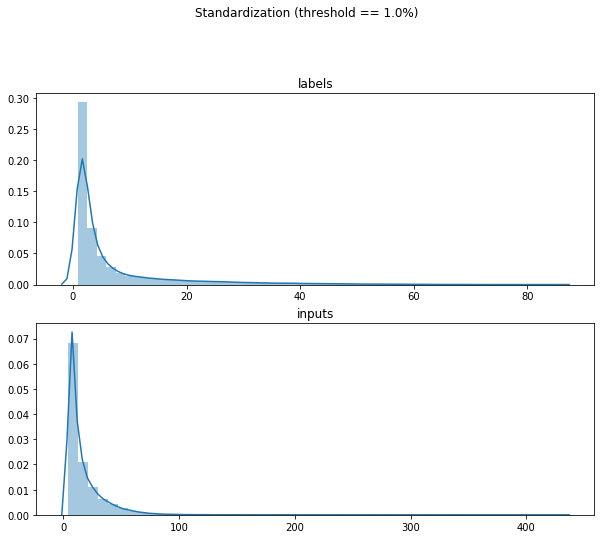

In [186]:
# PLOT DISTRIBUTION OF DOSE VOXEL VALUES
for name, arr in (('inputs', inputs), ('labels', labels)):
    print('{:s}: shape={!s}, size={:.0f}MB'.format(name.upper(), arr.shape, arr.nbytes/1024.0/1024.0))
    
threshold = 0.00 # ignore values below this fraction of data max

def plot_histo(inputs, labels, geoms, threshold=0.0, title=''):
    plt.figure(figsize=(10,12))
    ax = plt.subplot(3,1,1)
    sns.distplot(np.ravel(labels[labels>np.amax(labels)*threshold]), kde=True, ax=ax)
    _ = ax.set_title("labels")
    
    ax = plt.subplot(3,1,2)
    sns.distplot(np.ravel(inputs[inputs>np.amax(inputs)*threshold]), kde=True, ax=ax)
    _ = ax.set_title("inputs")
    
#    ax = plt.subplot(3,1,3)
#    sns.distplot(np.ravel(geoms), kde=False, ax=ax)
#    _ = ax.set_title("geoms")
    
    plt.suptitle('{!s} (threshold == {:0.1%})'.format(title, threshold))
    plt.show()

plot_histo(inputs, labels, geoms, threshold=0.01, title='Original Dist.')

# perform scaling to standard range [0, 1]
_max, _min = np.amax(labels), np.amin(labels)
sinputs = (inputs-_min)/(_max-_min)
slabels = (labels-_min)/(_max-_min)
plot_histo(sinputs, slabels, geoms, threshold=0.01, title="Scale Transform")

# check standardized distributions
_mean = np.mean(labels)
_std  = np.std( labels)
stinputs = (inputs - _mean) / _std
stlabels = (labels - _mean) / _std
plot_histo(stinputs, stlabels, geoms, threshold=0.01, title="Standardization")